# 2025-02-10 Advection

## Last time

* Variable coefficients
* Conservative/divergence form vs non-divergence forms
* Verification with discontinuities

## Today

* Advection and boundary layers
* The (cell) Péclet number and oscillations
* Godunov's Theorem

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function poisson_nondivergence(n, kappa, forcing; leftbc=(0, zero), rightbc=(0, zero), spoints=3)
    x = LinRange(-1, 1, n)
    L = zeros(n, n)
    rhs = forcing.(x)
    kappax = kappa.(x)
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        kappa_x = fdstencil(x[js], x[i], 1) * kappax[js]
        L[i, js] = -fdstencil(x[js], x[i], 2) .* kappax[i] - fdstencil(x[js], x[i], 1) * kappa_x
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], leftbc[1])
    if leftbc[1] == 1
        L[1, :] *= kappax[1]
    end
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], rightbc[1])
    if rightbc[1] == 1
        L[n, :] *= kappax[n]
    end
    rhs[1] = leftbc[2](x[1])
    rhs[n] = rightbc[2](x[n])
    x, L, rhs
end

function poisson_conservative(n, kappa, forcing; leftbc=(0, zero), rightbc=(0, zero))
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1)
        flux_R = kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1)
        js = i-1:i+1
        weights = -fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    if leftbc[1] == 0
        L[1, 1] = 1
        rhs[1] = leftbc[2](x[1])
        rhs[2:end] -= L[2:end, 1] * rhs[1]
        L[2:end, 1] .= 0
    end
    if rightbc[1] == 0
        L[end,end] = 1
        rhs[end] = rightbc[2](x[end])
        rhs[1:end-1] -= L[1:end-1,end] * rhs[end]
        L[1:end-1,end] .= 0
    end
    x, L, rhs
end
    
    
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

function chebdiff(x, n=nothing)
    T = vander_chebyshev(x, n)
    m, n = size(T)
    dT = zero(T)
    dT[:,2:3] = [one.(x) 4*x]
    for j in 3:n-1
        dT[:,j+1] = j * (2 * T[:,j] + dT[:,j-1] / (j-2))
    end
    ddT = zero(T)
    ddT[:,3] .= 4
    for j in 3:n-1
        ddT[:,j+1] = j * (2 * dT[:,j] + ddT[:,j-1] / (j-2))
    end
    T, dT, ddT
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end


my_spy (generic function with 1 method)

# Advection


* Advection represents transport of a substance or bulk quantity by the bulk motion of a fluid
* Unknown scalar field $u(t, x)$ is the local density of the material being transported
* Bulk motion of the fluid represented by the _vector_ field $w = (w_x, w_y, w_z)$ (which might be time- and position-dependent)
* The time-dependent model is

$$ u_t + \underbrace{(w u)_x}_{\nabla \cdot (w u )} = 0 $$

* $u(t,x) = u(0, x - tw)$

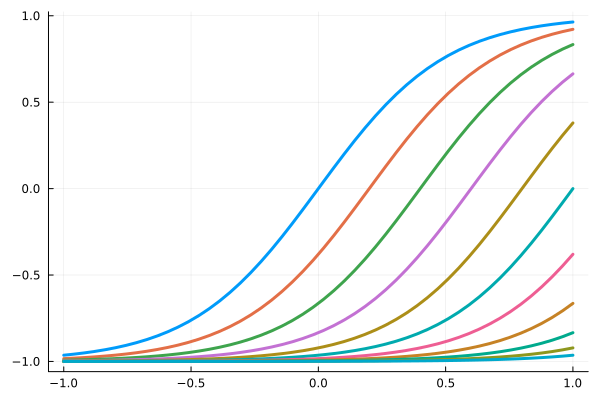

In [5]:
u0(x) = @. tanh(2*x)
usolution(t,x; w=1) = @. u0(x - t*w)
x = LinRange(-1, 1, 50)
plot(x, [usolution(t, x) for t in 0:.2:2], legend=:none)

* Where does this come from? 
    * flux: mass of material transported through unit area in unit time (dimensions: $ML^{-2}T^{-1}$)
    * $\to$ **advective** flux $= wu$ (check dimensions: $ M L^{-3} \cdot L T^{-1}$) 
    

   * Take 1D w.l.o.g., and notice that total change in mass in segment $[x_1, x_2]$ is due to incoming and outgoing flux on the left and right:
    $$ \frac{d}{dt} \int_{x_1}^{x_2} u(x, t) dx  = (wu)(x_1, t) - (wu)(x_2, t) $$
    

   * For smooth functions, rewrite right-hand-side
    $$ (wu)(x_1, t) - (wu)(x_2, t) = \int_{x_1}^{x_2} \frac{\partial}{\partial x} (wu) dx $$
    

   * Rearrange so that
    $$ \int_{x_1}^{x_2} dx (u_t + (wu)_x) = 0 $$
   * Since it needs to be true for all $x_1$, $x_2$, integrand has to be identically zero

# Diffusion

* Imagine a dye droplet being added to a glass of water
    * Spreads, even though water is still ($w = 0$)
    * Initial spread quick, then slows down; steady state is when density (concentration) is uniform
    * **Question**: what does that tell you about the flux (rate of spread) as a function of the density (concentration)? In other words, if $f_{\mathrm{diff}} \propto g(u)$, what is $g$?

* **Solution**: $f_{\mathrm{diff}} \propto \nabla u$, specifically $f_{\mathrm{diff}} - \kappa\nabla u$
* $\kappa$ is the (scalar) diffusivity, set to 1 for now
* Using the same continuity argument as earlier and adding a potential _source_ of flux $f$, 
$$ \underbrace{u_t}_{\text{ignore today}} + \underbrace{(wu)_x}_{\text{advection}} - \underbrace{u_{xx}}_{\text{diffusion }\\ \nabla \cdot (\kappa\nabla u)} = \underbrace{f}_{\text{source}} $$

## What boundary conditions can be specified on the steady-state ($t\to\infty$) problem?

## What is the steady state solution?

# Advection-diffusion with Chebyshev
$$ \underbrace{u_t}_{\text{ignore today}} + \underbrace{(wu)_x}_{\text{advection}} - \underbrace{u_{xx}}_{\text{diffusion}} = \underbrace{f}_{\text{source}} $$

In [9]:
function advdiff_cheb(n, wind, rhsfunc, leftbc=(0, zero), rightbc=(0, zero))
    x = CosRange(-1, 1, n)
    T, dT, ddT = chebdiff(x)
    dT /= T
    ddT /= T
    T /= T
    L = -ddT + wind * dT
    rhs = rhsfunc.(x)
    for (index, deriv, func) in
            [(1, leftbc...), (n, rightbc...)]
        L[index,:] = (T, dT)[deriv+1][index,:]
        rhs[index] = func(x[index])
    end
    x, L, rhs
end

advdiff_cheb (generic function with 3 methods)

minimum(diff(x)) = 0.0032426918657900705


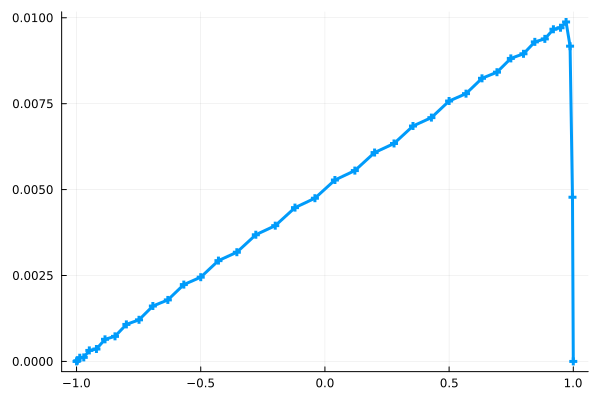

In [10]:
# Interpret this setup

wind = 200
x, L, rhs = advdiff_cheb(40, wind, one) # Reminder: advdiff_cheb(n, wind, rhsfunc, leftbc=(0, zero), rightbc=(0, zero))
@show minimum(diff(x)) # Columnwise difference in matrix
plot(x, L \ rhs, legend=:none, marker=:auto)

# Advection-diffusion with conservative FD

$$\big(wu - \kappa u_x\big)_x = f$$

* Reminder: if PDE is derived from a conserved quantity, conservative form is the one that expresses the PDE in terms of said quantity

In [5]:
function advdiff_conservative(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        # Recall: fdstencil(source, target, k)
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) + wind * [.5 .5]
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) + wind * [.5 .5]
        js = i-1:i+1
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_conservative (generic function with 1 method)

# Experiments, The (cell) [Péclet number](https://en.wikipedia.org/wiki/P%C3%A9clet_number)

\begin{align}
\big(wu - \kappa u_x\big)_x &= f & \mathrm{Pe}_h &= \frac{h \lvert w \rvert}{\kappa}
\end{align}

* Dimensionless quantity 
* Ratio of rate of advection and diffusion for the same substance/quantity
* **Question**: What does it mean for it to $\to 0$? $\to 1$? $\to \infty$?




minimum(diff(x)) = 0.03389830508474567


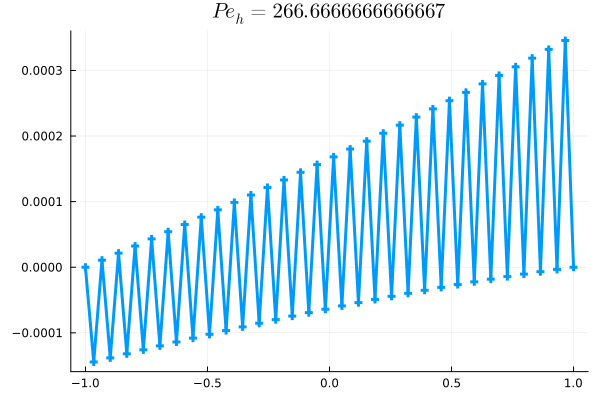

In [11]:
n = 60; h = 2/n
kappa = 1
wind = 8000
x, L, rhs = advdiff_conservative(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="\$Pe_h = $(wind*h/kappa)\$")

# Upwinded discretization

* Idea: incoming **advective flux** should depend only on upwind value, outgoing should depend only on "my" value
* i.e. derivatives computed using a set of nodes biased to be more "upwind" of the query (target) point

In [33]:
# Group discussion: what does this code do?

function advdiff_upwind(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1]) 
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        js = i-1:i+1
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_upwind (generic function with 1 method)

# Try it for robustness

minimum(diff(x)) = 0.06896551724137923


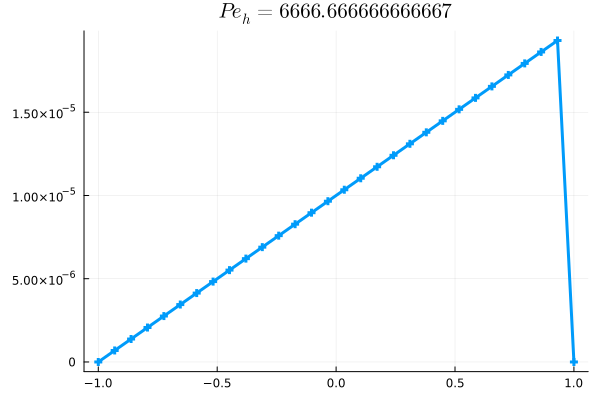

In [34]:
n = 30; h = 2/n
kappa = 1
wind = 100000
x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="\$Pe_h = $(wind*h/kappa)\$")

## What is the order of accuracy of the upwinded discretization?

# Godunov's Theorem (1954)

Linear numerical methods
$$ \dot u_i = \sum_j a_{ij} u_j $$
for solving time-dependent PDE can be at most first order accurate if they are monotone.

For our purposes, monotonicity is equivalent to positivity preservation,
$$ \min_x u(0, x) \ge 0 \quad \Longrightarrow \quad \min_x u(t, x) \ge 0 .$$

## Discontinuities

A numerical method for representing a discontinuous function on a stationary grid (const in time) can be no better than first order accurate in the $L^1$ norm,
$$ \lVert u - u^* \rVert_{L^1} = \int \lvert u - u^* \rvert . $$
If we merely sample a discontinuous function, say
$$ u(x) = \begin{cases} 0, & x \le a \\ 1, & x > a \end{cases} $$
onto a grid with element size $\Delta x$ then we will have errors of order 1 on an interval proportional to $\Delta x$.

In light of these two observations, we may still ask for numerical methods that are more than first order accurate for smooth solutions, but those methods must be nonlinear.

# Next week

* Sparse linear algebra (necessary for more than 1 spatial dimension)
* Nonlinear solvers
* Time integration for stiff and non-stiff systems

# How expensive is `\`?

In [35]:
x, L, rhs = advdiff_upwind(1000, x -> kappa, wind, one)
@timev L \ rhs;

  0.020222 seconds (9 allocations: 7.641 MiB, 27.29% gc time)
elapsed time (ns):  2.0221759e7
gc time (ns):       5519506
bytes allocated:    8012240
pool allocs:        6
non-pool GC allocs: 0
malloc() calls:     3
free() calls:       50
minor collections:  1
full collections:   0


In [36]:
function elapsed_solve(n)
    x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
    @elapsed L \ rhs
end
ns = (1:6) * 1000
times = elapsed_solve.(ns)

6-element Vector{Float64}:
 0.019633535
 0.071940361
 0.166576517
 0.332786683
 0.68706277
 1.043462831

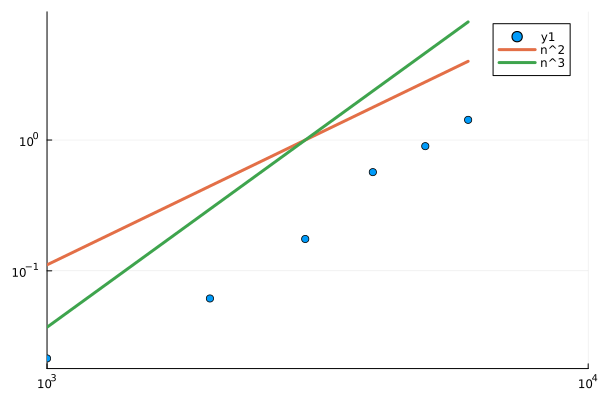

In [27]:
scatter(ns, times, xscale=:log10, yscale=:log10)
plot!(ns, [(ns/3000).^2, (ns/3000).^3], label=["n^2" "n^3"], xrange=(1e3, 1e4))

## How long would $n=10000$ take to solve?

## How much memory would $n=10000$ take?

# Sparsity

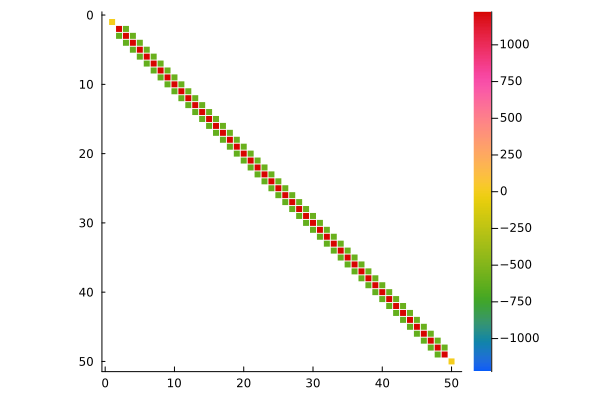

In [28]:
x, L, rhs = advdiff_upwind(50, one, 1, one)
my_spy(L)

In [29]:
using SparseArrays
sparse(L)

50×50 SparseMatrixCSC{Float64, Int64} with 144 stored entries:
⎡⠱⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠑⎦

# How does solving with the sparse matrix scale?

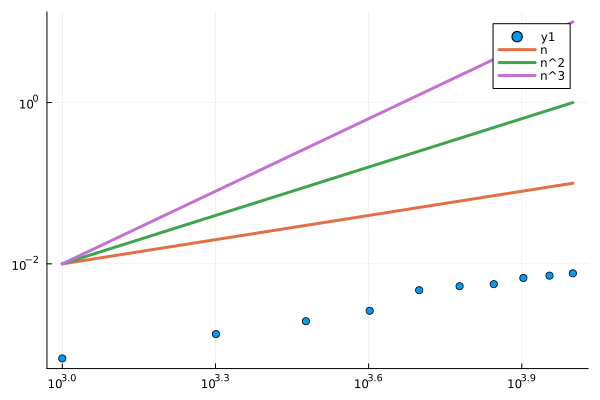

In [30]:
function elapsed_solve(n)
    x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
    L = sparse(L)
    @elapsed L \ x
end
ns = (1:10) * 1000
times = elapsed_solve.(ns)
scatter(ns, times, xscale=:log10, yscale=:log10)
plot!([n -> 1e-2*n/1000, n -> 1e-2*(n/1000)^2, n -> 1e-2*(n/1000)^3],
  label=["n" "n^2" "n^3"])

## How much memory is needed?